# Use the `Inversion` class

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import inversion_ideas as ii
from regressor import LinearRegressor

## Synthetic data

In [2]:
n_params = 10
rng = np.random.default_rng(seed=4242)
true_model = rng.uniform(size=10)
true_model

array([0.78225148, 0.67148671, 0.2373809 , 0.17946133, 0.34662367,
       0.15210999, 0.31142952, 0.23900652, 0.54355731, 0.91770851])

In [3]:
# Build the X matrix
n_data = 25
shape = (n_data, n_params)
X = rng.uniform(size=n_data * n_params).reshape(shape)

In [4]:
# Generate synthetic data with noise
synthetic_data = X @ true_model
maxabs = np.max(np.abs(synthetic_data))
std_err =  1e-2 * maxabs
noise = rng.normal(scale=std_err, size=synthetic_data.size)
synthetic_data += noise
synthetic_data

array([2.83840696, 2.18091081, 2.00623242, 2.08333039, 2.01694883,
       2.7826232 , 2.10564027, 1.27333506, 2.08859855, 1.94177648,
       1.88492037, 2.92394733, 2.17231952, 3.08009275, 1.61670886,
       1.77403753, 2.67305005, 1.91413882, 2.42117827, 2.13991628,
       2.0153805 , 2.71388471, 2.65944255, 2.44416121, 3.14217523])

## Inversion with beta scheduling

In [5]:
simulation = LinearRegressor(X, sleep=1)

In [6]:
uncertainty = std_err * np.ones_like(synthetic_data)
data_misfit = ii.DataMisfit(synthetic_data, uncertainty, simulation)
data_misfit

φd(m)

In [7]:
smallness = ii.TikhonovZero(n_params)
smallness

φs(m)

In [8]:
# Define objective function with starting beta
beta_0 = 1e4
regularization = beta_0 * smallness
phi = data_misfit + regularization

# Initial model
initial_model = np.zeros(n_params)

# Minimizer
minimizer = ii.ConjugateGradient()

# Beta cooling
beta_cooler = ii.MultiplierCooler(regularization, cooling_factor=2.0)

# Stopping criteria
chi_target = 1.0
stopping_criteria = ii.ChiTarget(data_misfit, chi_target=chi_target)

# Inversion
inversion = ii.Inversion(
    phi,
    initial_model,
    minimizer,
    directives=[beta_cooler],
    stopping_criteria=stopping_criteria,
    cache_models=True,
)

In [9]:
with inversion.log.live() as live:
    for model in inversion:
        # Refresh table
        live.refresh()

Output()

INFO: 🎉 Inversion successfully finished due to stopping critiera.


In [10]:
inverted_model = inversion.model
inverted_model

array([0.78781238, 0.63620172, 0.2461426 , 0.1941919 , 0.33960904,
       0.17601471, 0.32485498, 0.26662799, 0.52718998, 0.89311305])

In [11]:
print("Result:")
print(inverted_model)
print()
print("True model:")
print(true_model)

Result:
[0.78781238 0.63620172 0.2461426  0.1941919  0.33960904 0.17601471
 0.32485498 0.26662799 0.52718998 0.89311305]

True model:
[0.78225148 0.67148671 0.2373809  0.17946133 0.34662367 0.15210999
 0.31142952 0.23900652 0.54355731 0.91770851]


In [12]:
inversion.log.table

┏━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ iter ┃ beta     ┃ phi_d    ┃ phi_m    ┃ beta * phi_m ┃ phi      ┃ chi      ┃
┡━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ 0    │ 1.00e+04 │ 1.36e+05 │ 0.00e+00 │ 0.00e+00     │ 1.36e+05 │ 5.44e+03 │
│ 1    │ 1.00e+04 │ 3.28e+03 │ 1.51e+00 │ 1.51e+04     │ 1.84e+04 │ 1.31e+02 │
│ 2    │ 5.00e+03 │ 1.37e+03 │ 1.77e+00 │ 8.85e+03     │ 1.02e+04 │ 5.50e+01 │
│ 3    │ 2.50e+03 │ 5.80e+02 │ 1.99e+00 │ 4.97e+03     │ 5.55e+03 │ 2.32e+01 │
│ 4    │ 1.25e+03 │ 2.31e+02 │ 2.18e+00 │ 2.73e+03     │ 2.96e+03 │ 9.23e+00 │
│ 5    │ 6.25e+02 │ 8.70e+01 │ 2.34e+00 │ 1.46e+03     │ 1.55e+03 │ 3.48e+00 │
│ 6    │ 3.12e+02 │ 3.50e+01 │ 2.45e+00 │ 7.66e+02     │ 8.01e+02 │ 1.40e+00 │
│ 7    │ 1.56e+02 │ 1.83e+01 │ 2.52e+00 │ 3.94e+02     │ 4.12e+02 │ 7.34e-01 │
└──────┴──────────┴──────────┴──────────┴──────────────┴──────────┴──────────┘

In [13]:
df = pd.DataFrame(inversion.log.log).set_index("iter")
df

,beta,phi_d,phi_m,beta * phi_m,phi,chi
iter,,,,,,
0,10000.00,135973.462849,0.000000,0.000000,135973.462849,5438.938514
1,10000.00,3283.955124,1.508719,15087.188025,18371.143149,131.358205
2,5000.00,1373.851799,1.770045,8850.225213,10224.077012,54.954072
3,2500.00,580.052974,1.988480,4971.200876,5551.253850,23.202119
4,1250.00,230.779314,2.180556,2725.695257,2956.474571,9.231173
5,625.00,87.019569,2.337612,1461.007338,1548.026907,3.480783
6,312.50,34.986938,2.450452,765.766163,800.753102,1.399478
7,156.25,18.339748,2.522215,394.096024,412.435773,0.733590


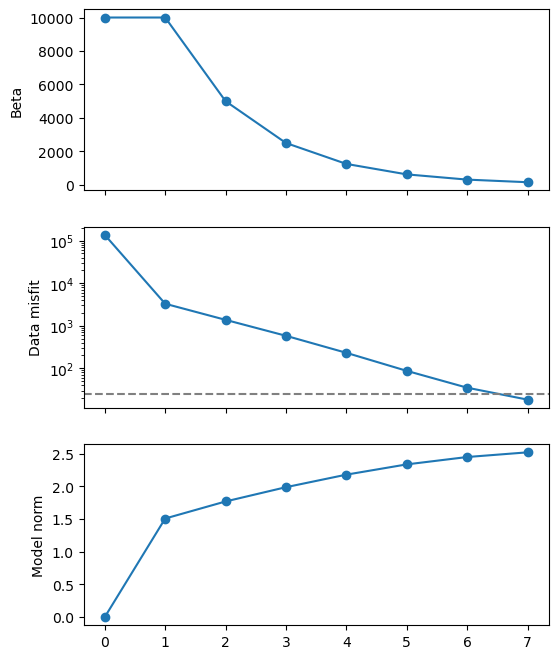

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(df.index, df.beta, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(df.index, df.phi_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(df.index, df.phi_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()

In [15]:
inversion.models

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.42435726, 0.42399556, 0.31488771, 0.30781909, 0.36748548,
        0.3541613 , 0.35617454, 0.33544115, 0.43090205, 0.51906374]),
 array([0.5056242 , 0.47292493, 0.31019533, 0.28663263, 0.38905159,
        0.34587771, 0.36311607, 0.33629102, 0.47778453, 0.60674237]),
 array([0.58936952, 0.51738738, 0.2902994 , 0.25123224, 0.39337984,
        0.3151884 , 0.35668177, 0.3233827 , 0.50991683, 0.6929199 ]),
 array([0.66606771, 0.55805404, 0.26845575, 0.21988974, 0.38401096,
        0.27327808, 0.34599733, 0.30631261, 0.52650139, 0.76952915]),
 array([0.72555055, 0.59250287, 0.25392942, 0.20191464, 0.36759678,
        0.23168433, 0.33632369, 0.29012319, 0.53109078, 0.82869251]),
 array([0.76485366, 0.61861644, 0.24767964, 0.19529472, 0.35147213,
        0.19846023, 0.32930081, 0.27659424, 0.52981675, 0.86874091]),
 array([0.78781238, 0.63620172, 0.2461426 , 0.1941919 , 0.33960904,
        0.17601471, 0.32485498, 0.26662799, 0.52718998

### Manually running iterations

In [16]:
# Define objective function with starting beta
beta_0 = 1e4
regularization = beta_0 * smallness
phi = data_misfit + regularization

# Beta cooling
beta_cooler = ii.MultiplierCooler(regularization, cooling_factor=2.0)

# Inversion
inversion = ii.Inversion(
    phi,
    initial_model,
    minimizer,
    directives=[beta_cooler],
    stopping_criteria=stopping_criteria,
    cache_models=True,
)

In [17]:
print(inversion.counter)

0


In [18]:
model = next(inversion)
model

array([0.42435726, 0.42399556, 0.31488771, 0.30781909, 0.36748548,
       0.3541613 , 0.35617454, 0.33544115, 0.43090205, 0.51906374])

In [19]:
print(inversion.counter)

1


### Break iterations at any point and continue

In [20]:
# Define objective function with starting beta
beta_0 = 1e4
regularization = beta_0 * smallness
phi = data_misfit + regularization

# Beta cooling
beta_cooler = ii.MultiplierCooler(regularization, cooling_factor=2.0)

# Inversion
inversion = ii.Inversion(
    phi,
    initial_model,
    minimizer,
    directives=[beta_cooler],
    stopping_criteria=stopping_criteria,
    cache_models=True,
)

In [21]:
with inversion.log.live() as live:
    for model in inversion:
        # Refresh table
        live.refresh()

        if inversion.counter == 4:
            break

Output()

We can checkout the model, convergence curves, etc:

In [22]:
print("Result:")
print(inversion.model)
print()
print("True model:")
print(true_model)

Result:
[0.66606771 0.55805404 0.26845575 0.21988974 0.38401096 0.27327808
 0.34599733 0.30631261 0.52650139 0.76952915]

True model:
[0.78225148 0.67148671 0.2373809  0.17946133 0.34662367 0.15210999
 0.31142952 0.23900652 0.54355731 0.91770851]


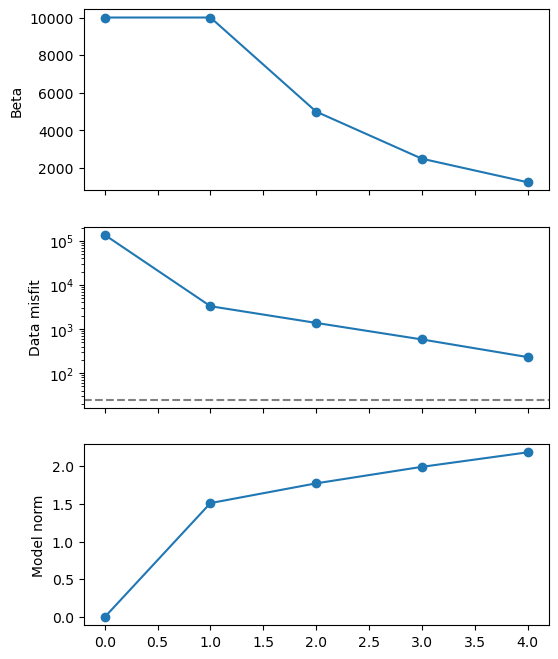

In [23]:
df = pd.DataFrame(inversion.log.log).set_index("iter")

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(df.index, df.beta, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(df.index, df.phi_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(df.index, df.phi_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()

We can then continue iterating manually

In [24]:
model = next(inversion)
model

array([0.72555055, 0.59250287, 0.25392942, 0.20191464, 0.36759678,
       0.23168433, 0.33632369, 0.29012319, 0.53109078, 0.82869251])

In [25]:
inversion.log.table

┏━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ iter ┃ beta     ┃ phi_d    ┃ phi_m    ┃ beta * phi_m ┃ phi      ┃ chi      ┃
┡━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ 0    │ 1.00e+04 │ 1.36e+05 │ 0.00e+00 │ 0.00e+00     │ 1.36e+05 │ 5.44e+03 │
│ 1    │ 1.00e+04 │ 3.28e+03 │ 1.51e+00 │ 1.51e+04     │ 1.84e+04 │ 1.31e+02 │
│ 2    │ 5.00e+03 │ 1.37e+03 │ 1.77e+00 │ 8.85e+03     │ 1.02e+04 │ 5.50e+01 │
│ 3    │ 2.50e+03 │ 5.80e+02 │ 1.99e+00 │ 4.97e+03     │ 5.55e+03 │ 2.32e+01 │
│ 4    │ 1.25e+03 │ 2.31e+02 │ 2.18e+00 │ 2.73e+03     │ 2.96e+03 │ 9.23e+00 │
│ 5    │ 6.25e+02 │ 8.70e+01 │ 2.34e+00 │ 1.46e+03     │ 1.55e+03 │ 3.48e+00 │
└──────┴──────────┴──────────┴──────────┴──────────────┴──────────┴──────────┘

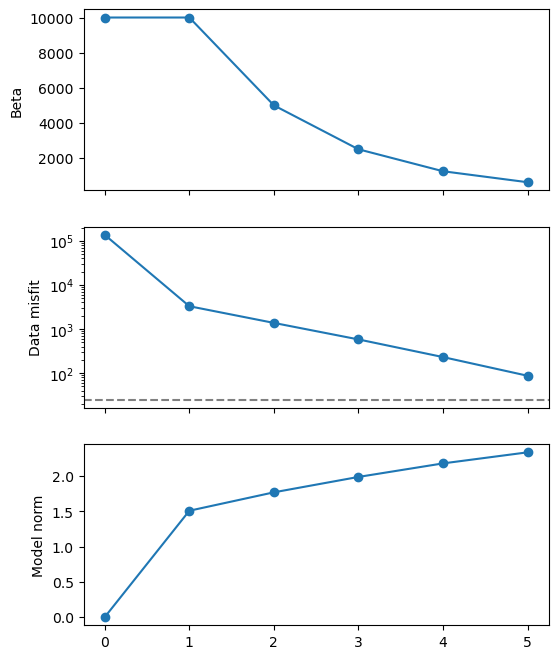

In [26]:
df = pd.DataFrame(inversion.log.log).set_index("iter")

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(df.index, df.beta, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(df.index, df.phi_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(df.index, df.phi_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()

And we can keep iterating until stopping criteria is met:

In [27]:
with inversion.log.live() as live:
    for model in inversion:
        # Refresh table
        live.refresh()

Output()

INFO: 🎉 Inversion successfully finished due to stopping critiera.


In [28]:
print("Result:")
print(inversion.model)
print()
print("True model:")
print(true_model)

Result:
[0.78781238 0.63620172 0.2461426  0.1941919  0.33960904 0.17601471
 0.32485498 0.26662799 0.52718998 0.89311305]

True model:
[0.78225148 0.67148671 0.2373809  0.17946133 0.34662367 0.15210999
 0.31142952 0.23900652 0.54355731 0.91770851]


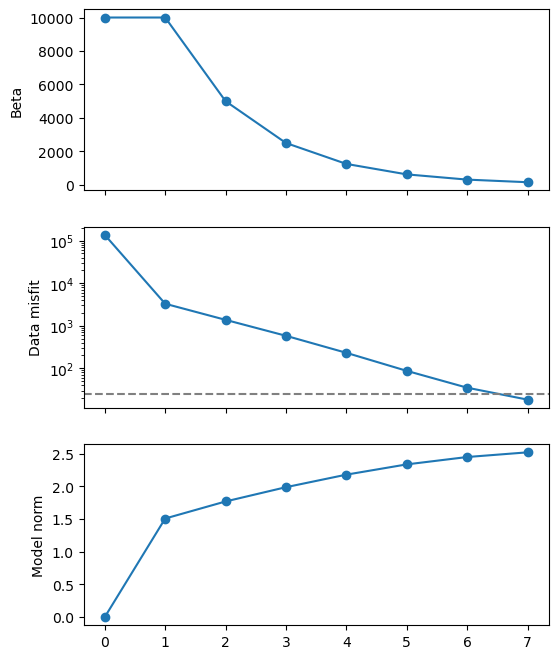

In [29]:
df = pd.DataFrame(inversion.log.log).set_index("iter")

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(df.index, df.beta, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(df.index, df.phi_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(df.index, df.phi_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()

## Use the `.run()` method

In [30]:
# Define objective function with starting beta
beta_0 = 1e4
regularization = beta_0 * smallness
phi = data_misfit + regularization

# Beta cooling
beta_cooler = ii.MultiplierCooler(regularization, cooling_factor=2.0)

# Inversion
inversion = ii.Inversion(
    phi,
    initial_model,
    minimizer,
    directives=[beta_cooler],
    stopping_criteria=stopping_criteria,
    cache_models=True,
)

In [31]:
model = inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping critiera.


In [32]:
print("Result:")
print(inversion.model)
print()
print("True model:")
print(true_model)

Result:
[0.78781238 0.63620172 0.2461426  0.1941919  0.33960904 0.17601471
 0.32485498 0.26662799 0.52718998 0.89311305]

True model:
[0.78225148 0.67148671 0.2373809  0.17946133 0.34662367 0.15210999
 0.31142952 0.23900652 0.54355731 0.91770851]


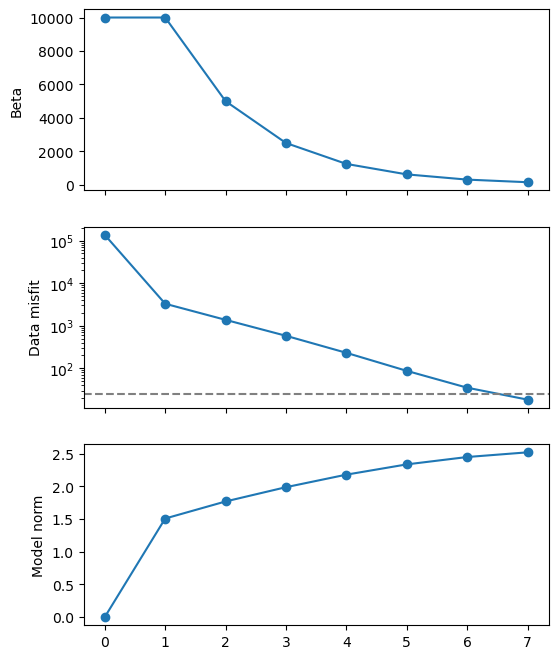

In [33]:
df = pd.DataFrame(inversion.log.log).set_index("iter")

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(df.index, df.beta, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(df.index, df.phi_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(df.index, df.phi_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()